In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import os
import seaborn as sns

import lrp
import utility

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

This time series forecasting is heavily inspired by https://www.tensorflow.org/tutorials/structured_data/time_series 

# Load the dataset and classifier

In [ ]:
# Valid datasets are "WEATHER"
dataset = "WEATHER" 
# You can either train a model or load a model
mode = "load"

The initial preprocesing is taken over from https://www.tensorflow.org/tutorials/structured_data/time_series

In [4]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [6]:
df = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [9]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

In [10]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

In [ ]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [77]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)].reset_index(drop = True)
test_df = df[int(n*0.7):].reset_index(drop = True)

num_features = df.shape[1]

In [78]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [90]:
def create_windowed_data(df, support_len, query_len, target_column):
    """This function slices our dataframe into slices for x (support_len) and y (query_len)

    Args:
        df (pd.DataFrame): Dataframe containing target_column
        support_len (int): Length of x snippets
        query_len (int): length of prediction
        target_column (str): Name of target column in dataframe

    Returns:
        tuple(x,y): sliced x and y
    """
    total_width = support_len + query_len
    slicers_x = [slice(i, i+support_len-1, 1) for i in range(0,len(df)-total_width)]
    slicers_y = [slice(i+support_len, i+support_len+query_len-1, 1) for i in range(0,len(df)-total_width)]
    x = np.array([df.loc[s,:].to_numpy() for s in slicers_x])
    y = np.array([df.loc[s,target_column].to_numpy() for s in slicers_y])
    return x.reshape(-1, support_len, 1, 15), y

In [88]:
train_df.columns

Index(['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'Wx', 'Wy', 'max Wx', 'max Wy'],
      dtype='object')

In [89]:
test_df.columns

Index(['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'Wx', 'Wy', 'max Wx', 'max Wy'],
      dtype='object')

In [91]:
x_train, y_train = create_windowed_data(train_df, 80, 1, "T (degC)")
x_test, y_test = create_windowed_data(test_df, 80, 1, "T (degC)")

In [ ]:
(x_train, y_train, x_test, y_test) = utility.load_dataset(dataset)

## Train a model or load a model

In [5]:
classifier = utility.get_classifier(dataset = dataset, mode = mode, data = (x_train, y_train, x_test, y_test), save_model = False)

Loading model ...


# Creating Explanations using the explainer

## Create an explainer object

In [18]:
# To define an LRP explainer, you have to define an LRP-process
if dataset == "MNIST":
    lrp_process = ["final", "ab", "avg", "ab", "ab", "avg", "flatten", "eps", "0"]
    # lrp_process = ["final", "ab", "bn", "avg", "ab", "ab", "bn", "avg", "flatten", "eps", "0"] # use this if BN layer is used
elif dataset == "CIFAR10":
    lrp_process = ["final", "ab", "max", "ab", "ab", "avg", "ab", "ab", "ab", "avg", "ab", "ab", "ab", "avg", "ab", "ab", "ab", "avg", "flatten", "eps","eps", "0"]

In [19]:
explainer = lrp.LrpExplainer(classifier, 
                             lrp_process, # This LRP process must define a rule for each layer. for reference what rule to choose, see here: https://iphome.hhi.de/samek/pdf/MonXAI19.pdf
                             a = 2, b = -1,  # These are hyper parameters a & b, according to LRP specificationsw
                             verbose = True) # Enables additional printouts and returns of the relprop function

### As verbose is True, additional logs are printed and returned

In [20]:
img = x_test[1,...]
label = y_test[1,...]

calculating LRP of  <keras.engine.functional.Functional object at 0x0000029A5622E080>
['final', 'ab', 'max', 'ab', 'ab', 'avg', 'ab', 'ab', 'ab', 'avg', 'ab', 'ab', 'ab', 'avg', 'ab', 'ab', 'ab', 'avg', 'flatten', 'eps', 'eps', '0']
###################
getting values
propagating relevance regarding classification:  8
In layer  -1  :  <keras.layers.core.dense.Dense object at 0x0000029A567ED6F0>  check-value:  0.9978499218183148
In layer  -2  :  <keras.layers.core.dense.Dense object at 0x0000029A567ED6C0>  check-value:  0.9925279552925252
In layer  -3  :  <keras.layers.reshaping.flatten.Flatten object at 0x0000029A567ED3C0>  check-value:  0.9925279552925252
In layer  -4  :  <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000029A567ED060>  check-value:  0.99252826
In layer  -5  :  <keras.layers.convolutional.conv2d.Conv2D object at 0x0000029A567ECB20>  check-value:  0.992527
In layer  -6  :  <keras.layers.convolutional.conv2d.Conv2D object at 0x0000029A567EC850>  check-value

Text(0.5, 1.0, '$y_{true}$ = 8, $y_{pred}$ = 8')

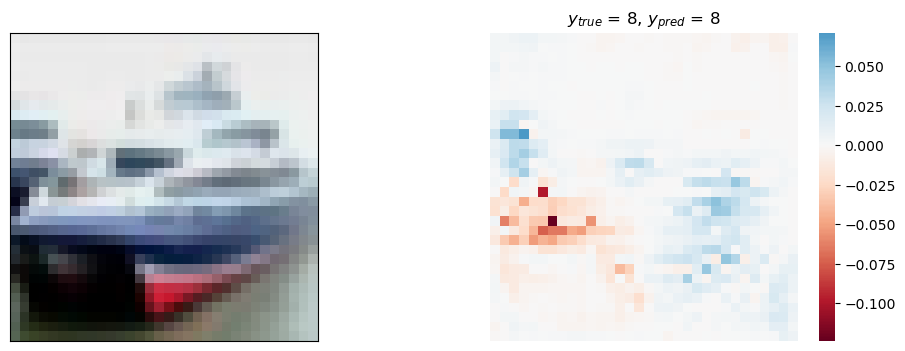

In [22]:
fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12,4))
R, inputs, outputs, weights, biases, rs = explainer.relprop(img, label)
for a in axs:
    a.axes.xaxis.set_visible(False)
    a.axes.yaxis.set_visible(False)
if img.shape[2] == 1:
    axs[0].imshow(utility.transform_image(img)[:,:,0],cmap='gray')
else:
    axs[0].imshow(utility.transform_image(img)[:,:,:])
y_pred = classifier.predict(img.reshape([1]+list(img.shape)))
sns.heatmap(R[0,:,:,:].sum(axis=-1),center=0, vmax=np.max(R[0,:,:,:].sum(axis=-1)), vmin=np.min(R[0,:,:,:].sum(axis=-1)),cmap="RdBu", square = True, ax = axs[1])
axs[1].set_title(str('$y_{true}$'+" = "+str(np.argmax(label))+ ', $y_{pred}$'+" = "+str(np.argmax(y_pred))))

# Creating an adversarial attack and checking out the result

For the sake of this demonstration, we set verbose to False as to not get too many relprop log printouts.

The first run is without early_stopping enabled.

In [23]:
explainer.verbose = False

In [24]:
adv_img_flip = explainer.flip_attack(img, label, flips = 100, early_stopping = False)
adv_img_ifgsm = explainer.ifgsm_attack(img, label, flips = 100, eps = 2/256, early_stopping = False)
adv_img_lrp = explainer.lrp_attack_batch_grad(img, label, flips = 100, batch = 40, eps = 2/256, early_stopping = False)
adv_imgs = dict({"flip": utility.transform_image(adv_img_flip),
                "ifgsm": utility.transform_image(adv_img_ifgsm),
                "lrp-grad": utility.transform_image(adv_img_lrp)})

1/1 [==============================] - 0s 36ms/step


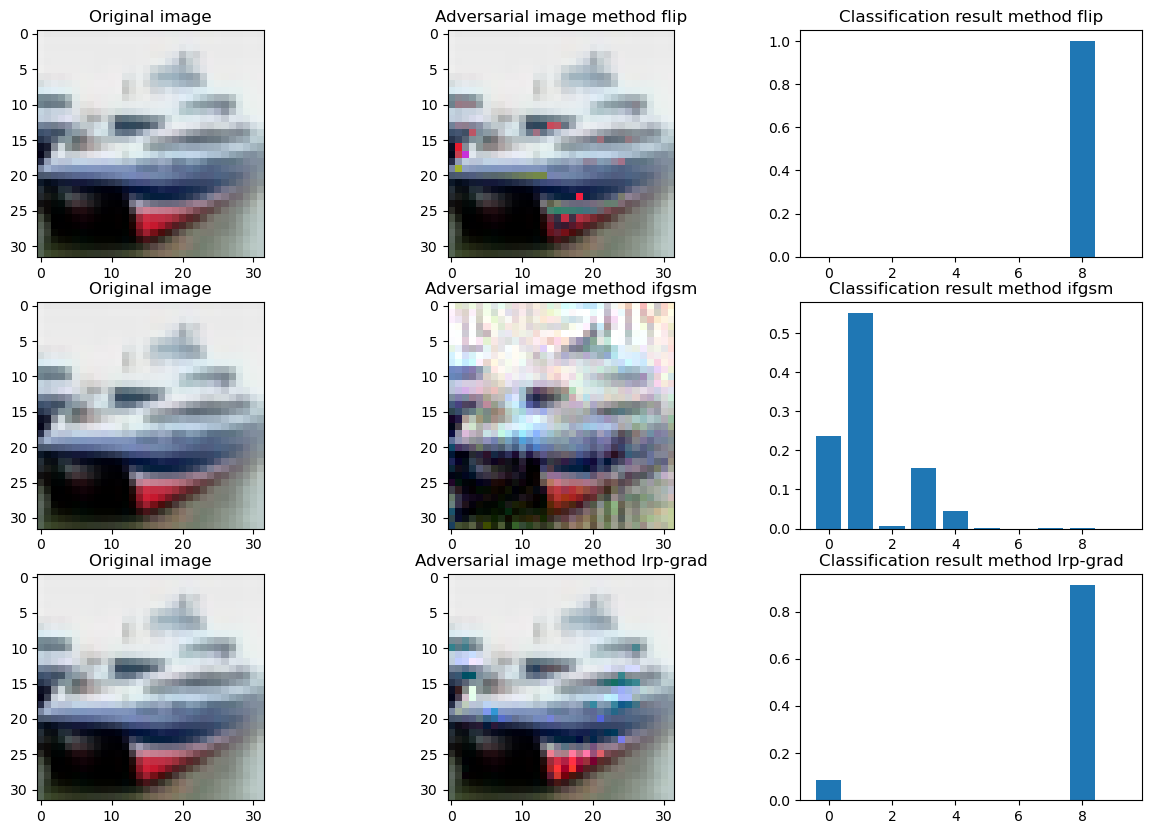

In [25]:
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (15,10))

for i, method in enumerate(adv_imgs.keys()):
    if img.shape[-1] == 1:
        axs[i,0].imshow(utility.transform_image(img),cmap='gray')
        axs[i,1].imshow(adv_imgs[method],cmap='gray')
    elif img.shape[-1] == 3:
        axs[i,0].imshow(utility.transform_image(img))
        axs[i,1].imshow(adv_imgs[method])
    axs[i,0].set_title("Original image")
    axs[i,1].set_title(f"Adversarial image method {method}")
    axs[i,2].bar(range(0,10), classifier.predict(adv_imgs[method].reshape([1]+ list(adv_imgs[method].shape)))[0])
    axs[i,2].set_title(f"Classification result method {method}")

Enabling early stopping leads to reduced manipulation of adversarial images.

In [26]:
adv_img_flip = explainer.flip_attack(img, label, flips = 100, early_stopping = True)
adv_img_ifgsm = explainer.ifgsm_attack(img, label, flips = 100, eps = 2/256, early_stopping = True)
adv_img_lrp = explainer.lrp_attack_batch_grad(img, label, flips = 100, batch = 20, eps = 2/256, early_stopping = True)
adv_imgs = dict({"flip": utility.transform_image(adv_img_flip),
                "ifgsm": utility.transform_image(adv_img_ifgsm),
                "lrp-grad": utility.transform_image(adv_img_lrp)})

1/1 [==============================] - 0s 41ms/step


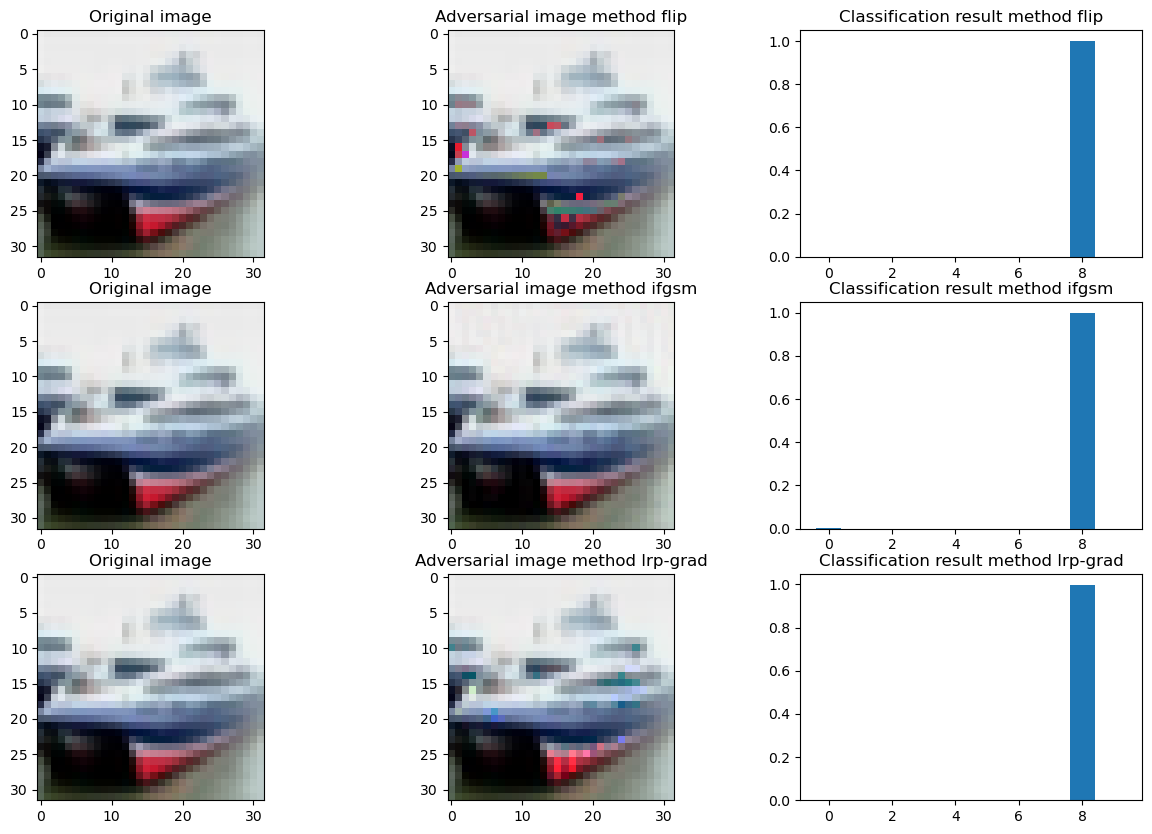

In [27]:
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (15,10))

for i, method in enumerate(adv_imgs.keys()):
    if img.shape[-1] == 1:
        axs[i,0].imshow(utility.transform_image(img),cmap='gray')
        axs[i,1].imshow(adv_imgs[method],cmap='gray')
    elif img.shape[-1] == 3:
        axs[i,0].imshow(utility.transform_image(img))
        axs[i,1].imshow(adv_imgs[method])
    axs[i,0].set_title("Original image")
    axs[i,1].set_title(f"Adversarial image method {method}")
    axs[i,2].bar(range(0,10), classifier.predict(adv_imgs[method].reshape([1]+ list(adv_imgs[method].shape)))[0])
    axs[i,2].set_title(f"Classification result method {method}")

The following graph highlights the improvement in image manupulation that early stopping delivers

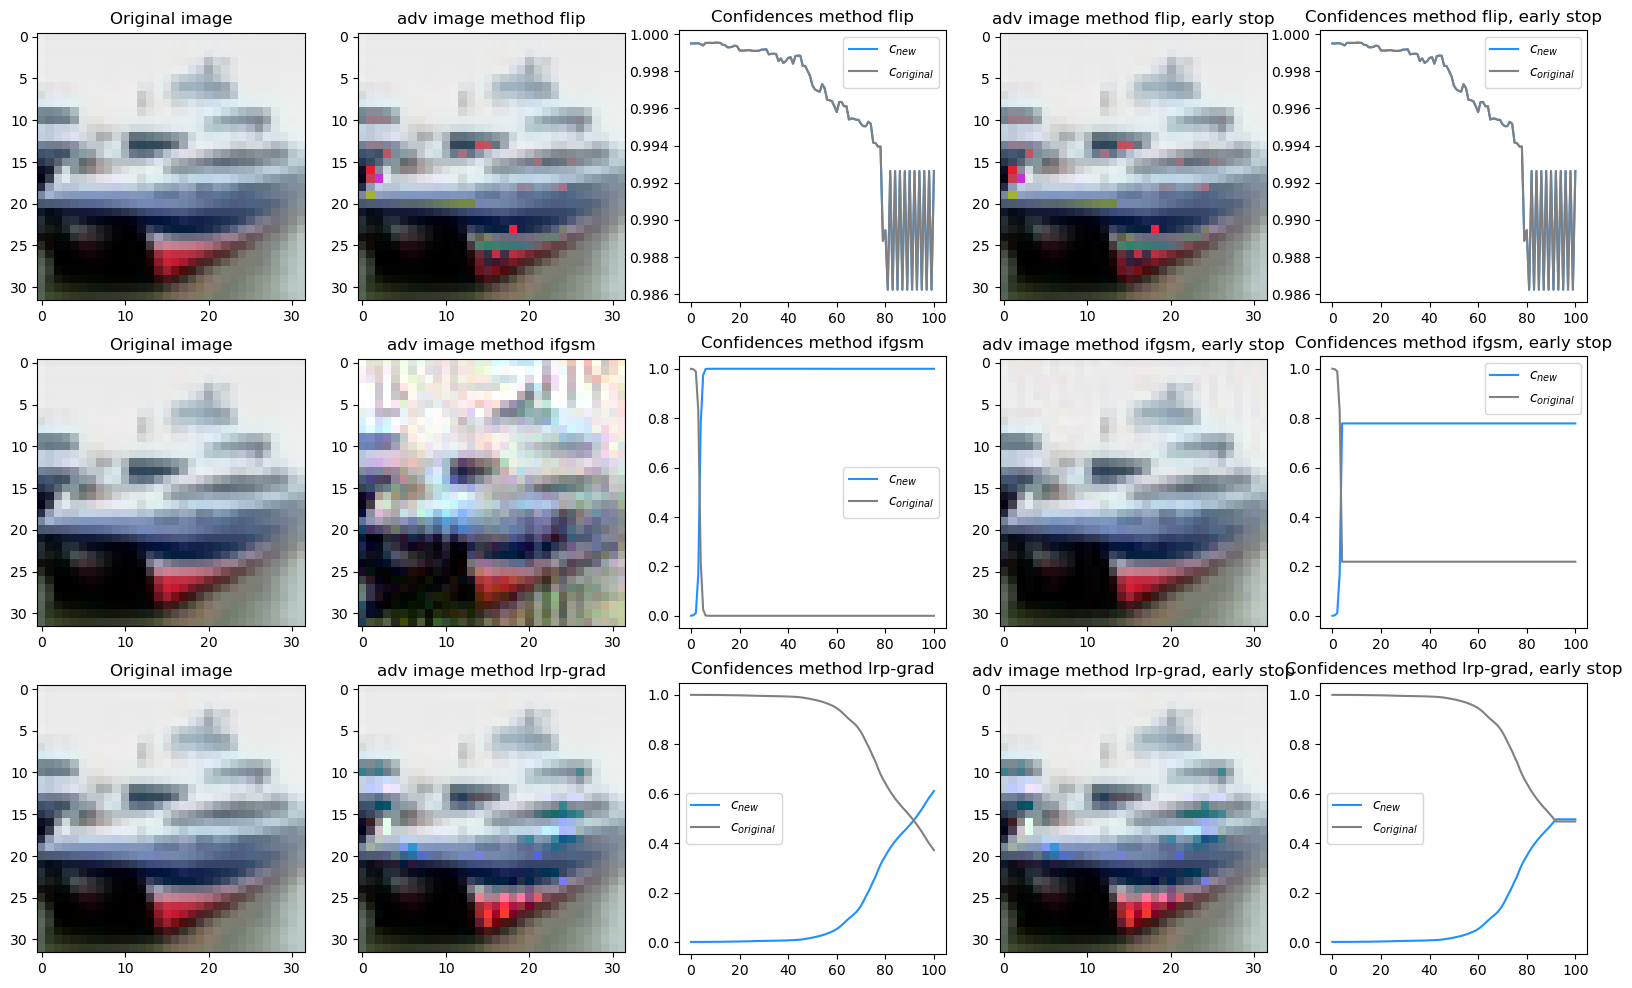

In [28]:
fig, axs = plt.subplots(nrows = 3, ncols = 5, figsize = (20,12))
methods = ["flip", "ifgsm", "lrp-grad"]
for i, method in enumerate(methods):
    if method == "flip":
        adv_img, y, y_new, y_log, r_log, img_log = explainer.flip_attack(img, label, flips = 100, early_stopping = False, log = True)
    elif method == "ifgsm":
        adv_img, y, y_new, y_log, r_log, img_log = explainer.ifgsm_attack(img, label, flips = 100, eps = 2/256, early_stopping = False, log = True)
    elif method == "lrp-grad":
        adv_img, y, y_new, y_log, r_log, img_log = explainer.lrp_attack_batch_grad(img, label, flips = 100, batch = 40, eps = 2/256, early_stopping = False, log = True)

    if img.shape[-1] == 1:
        axs[i,0].imshow(utility.transform_image(img),cmap='gray')
        axs[i,1].imshow(utility.transform_image(adv_img),cmap='gray')
    elif img.shape[-1] == 3:
        axs[i,0].imshow(utility.transform_image(img))
        axs[i,1].imshow(utility.transform_image(adv_img))
    axs[i,0].set_title("Original image")
    axs[i,1].set_title(f"adv image method {method}")    
    axs[i,2].set_title(f"Confidences method {method}")
    axs[i,2].plot(np.array(y_log)[:,[y_log[-1].argmax()]], c = "dodgerblue", label = "$c_{new}$")
    axs[i,2].plot(np.array(y_log)[:,[label.argmax()]], c = "gray", label = "$c_{original}$")
    axs[i,2].legend()

    if method == "flip":
        adv_img, y, y_new, y_log, r_log, img_log = explainer.flip_attack(img, label, flips = 100, early_stopping = True, log = True)
    elif method == "ifgsm":
        adv_img, y, y_new, y_log, r_log, img_log = explainer.ifgsm_attack(img, label, flips = 100, eps = 2/256, early_stopping = True, log = True)
    elif method == "lrp-grad":
        adv_img, y, y_new, y_log, r_log, img_log = explainer.lrp_attack_batch_grad(img, label, flips = 100, batch = 40, eps = 2/256, early_stopping = True, log = True)
    
    if img.shape[-1] == 1:
        axs[i,3].imshow(utility.transform_image(adv_img),cmap='gray')
    elif img.shape[-1] == 3:
        axs[i,3].imshow(utility.transform_image(adv_img))
    axs[i,3].set_title(f"adv image method {method}, early stop")    
    axs[i,4].set_title(f"Confidences method {method}, early stop")
    axs[i,4].plot(np.array(y_log)[:,[y_log[-1].argmax()]], c = "dodgerblue", label = "$c_{new}$")
    axs[i,4].plot(np.array(y_log)[:,[label.argmax()]], c = "gray", label = "$c_{original}$")
    axs[i,4].legend()
